# Predict Orders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from catboost import CatBoostRegressor

/home/dmitrii/Documents/Work/04_VkusWill/vw_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('dark_background')

## Defs

In [3]:
class SortIndexTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Ничего не делаем на этапе fit

    def transform(self, X):
        return X.sort_index()  # Сортировка индекса

In [4]:
class ResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, freq='1h'):
        self.freq = freq

    def fit(self, X, y=None):
        return self  # Ничего не делаем на этапе fit

    def transform(self, X):
        return X.resample(self.freq).size().to_frame('orders')  # Ресемплинг с агрегацией и преобразование в DataFrame

In [5]:
class ProphetTransformer(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = Prophet()

    def fit(self, X, y=None):
        df = pd.DataFrame({'ds': X.index, 'y': y})
        self.model.fit(df)
        return self

    def predict(self, X):
        future = pd.DataFrame({'ds': X.index})
        forecast = self.model.predict(future)
        return forecast[['ds', 'trend', 'additive_terms', 'yhat', 'daily']]

## Data preprocessing

In [6]:
# Specify the path to your Excel file
file_path = 'data/orders_4757.xlsx'

# Read the Excel file into a DataFrame
orders = pd.read_excel(file_path)

In [7]:
orders.head()

,Дата,час_оформления,Дата_поставки,ТТ,Тип_заказа,Подтип,Подтип_исх,Сервис,Тип сервиса,id_order,...,id_general_new,Отменил заказ,Номер исходного заказа,id_general,suborder,Партнер,Тип_партнера,Номер_ПСЕ,Адрес_ПСЕ,Тип курьера
0,2024-06-24,0,2024-06-24,4757ДС_Ленинградский80,Даркстор,ЗиЗ-14,ЗиЗ-14,Доставка сейчас ...,ГОРОД,309186503,...,NaN,NaN,NaN,309186503,1,NaN,NaN,NaN,NaN,Вело Свой
1,2024-06-24,0,2024-06-24,4757ДС_Ленинградский80,Даркстор,ЗиЗ-05,ЗиЗ-05,Доставка за 1 час ...,ГОРОД,309186723,...,NaN,NaN,NaN,309186723,1,NaN,NaN,NaN,NaN,Ночной Вело Курьер
2,2024-06-24,0,2024-06-24,4757ДС_Ленинградский80,Даркстор,ЗиЗ-05,ЗиЗ-05,Доставка за 1 час ...,ГОРОД,309187220,...,NaN,NaN,NaN,309187220,1,NaN,NaN,NaN,NaN,Авто
3,2024-06-24,0,2024-06-24,4757ДС_Ленинградский80,Даркстор,ЗиЗ-15,ЗиЗ-15,Доставка за 30 минут ...,ГОРОД,309187221,...,NaN,NaN,NaN,309187221,1,NaN,NaN,NaN,NaN,Авто
4,2024-06-24,0,2024-06-24,4757ДС_Ленинградский80,Даркстор,ЗиЗ-14,ЗиЗ-14,Доставка сейчас ...,ГОРОД,309187336,...,NaN,NaN,NaN,309187336,1,NaN,NaN,NaN,NaN,Авто


In [8]:
orders.set_index('Оформлен', inplace=True)

проверим по порядку идут данные или нет

In [9]:
orders.index.is_monotonic_increasing

False

отсортируем данные по порядку

In [10]:
orders = orders.sort_index()

In [11]:
orders.index.is_monotonic_increasing

True

In [12]:
orders_h = pd.DataFrame({'orders' : orders.resample('1h').size()})

In [13]:
orders_h.sample(5)

,orders
Оформлен,
2024-06-29 15:00:00,140
2024-07-03 22:00:00,65
2024-07-02 23:00:00,44
2024-06-27 09:00:00,200
2024-07-06 15:00:00,123


### EDA

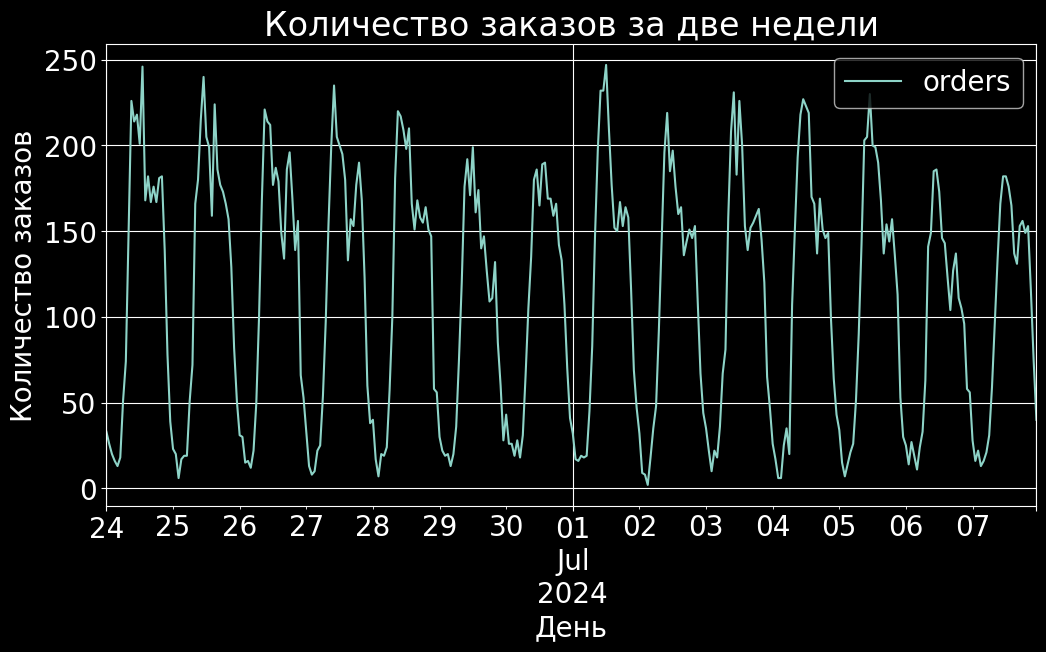

In [14]:
ax = orders_h.plot(figsize=(12,6),
        grid=True,
        fontsize=20);
ax.legend(fontsize=20)
ax.set_xlabel('День', fontsize = 20)
ax.set_ylabel('Количество заказов', fontsize = 20)
plt.title('Количество заказов за две недели', fontsize = 24);

Text(0.5, 1.0, 'Гистрограмма для количества заказов')

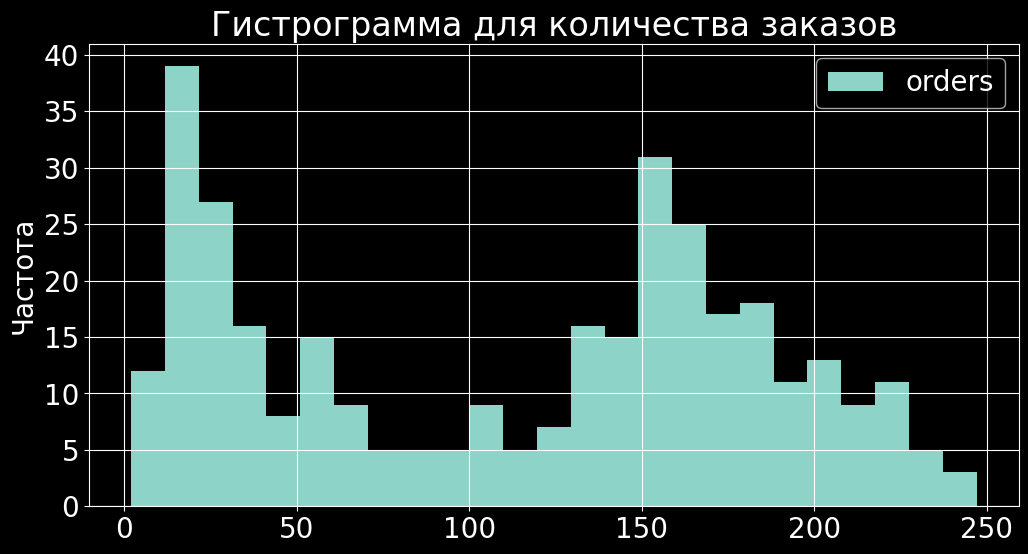

In [15]:
ax = orders_h.plot(kind='hist',
        figsize=(12,6),
        grid=True,
        bins=25,
        fontsize=20);


ax.legend(fontsize=20)
ax.set_ylabel('Частота', fontsize = 20)
plt.title('Гистрограмма для количества заказов', fontsize = 24)

#### Trend

In [16]:
decomposed = seasonal_decompose(orders_h)

Text(0, 0.5, 'Количество заказов')

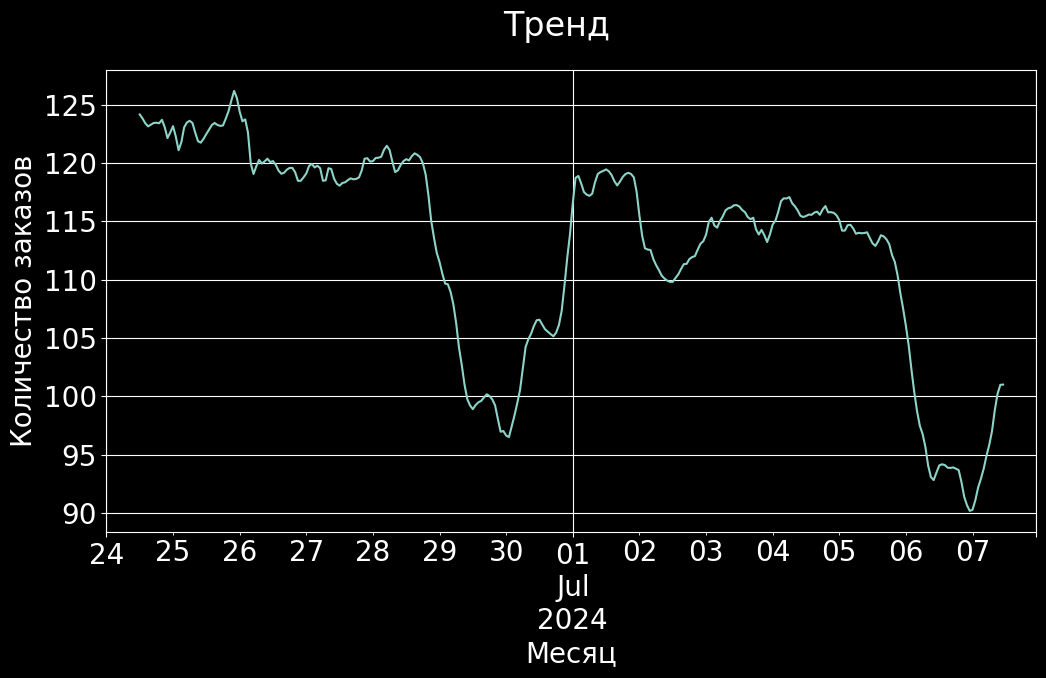

In [17]:
decomposed.trend.plot(ax=plt.gca(),
                      figsize=(12,6),
                      fontsize=20)
plt.grid()
plt.suptitle('Тренд', fontsize=24)
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Количество заказов', fontsize=20)

#### Saesonal

Text(0, 0.5, 'Сезонная составляющая')

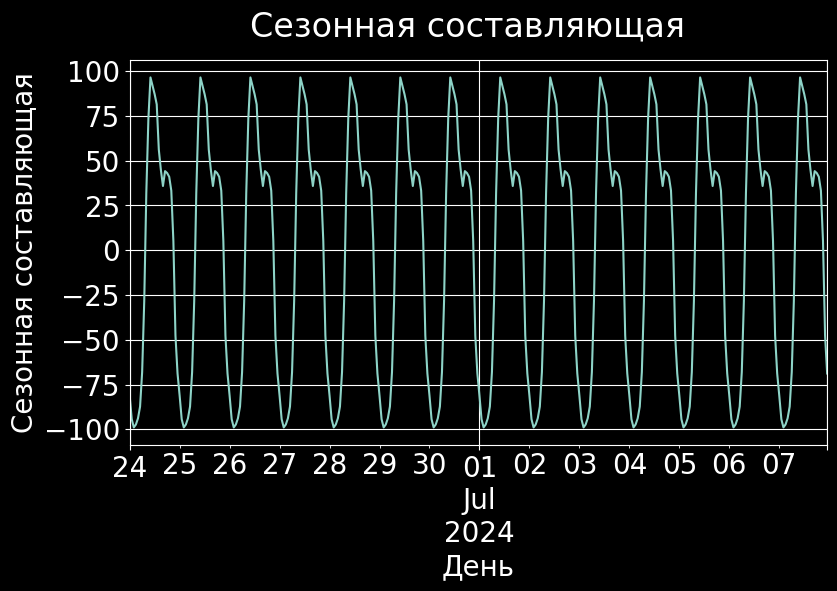

In [18]:
decomposed.seasonal['2024-06-24':'2024-07-07'].plot(ax=plt.gca(),
                                                   figsize=(9,5),
                                                   grid=True,
                                                   fontsize=20)

plt.suptitle('Сезонная составляющая', fontsize=24)
plt.xlabel('День', fontsize=20)
plt.ylabel('Сезонная составляющая', fontsize=20)

Text(0, 0.5, 'Сезонная составляющая')

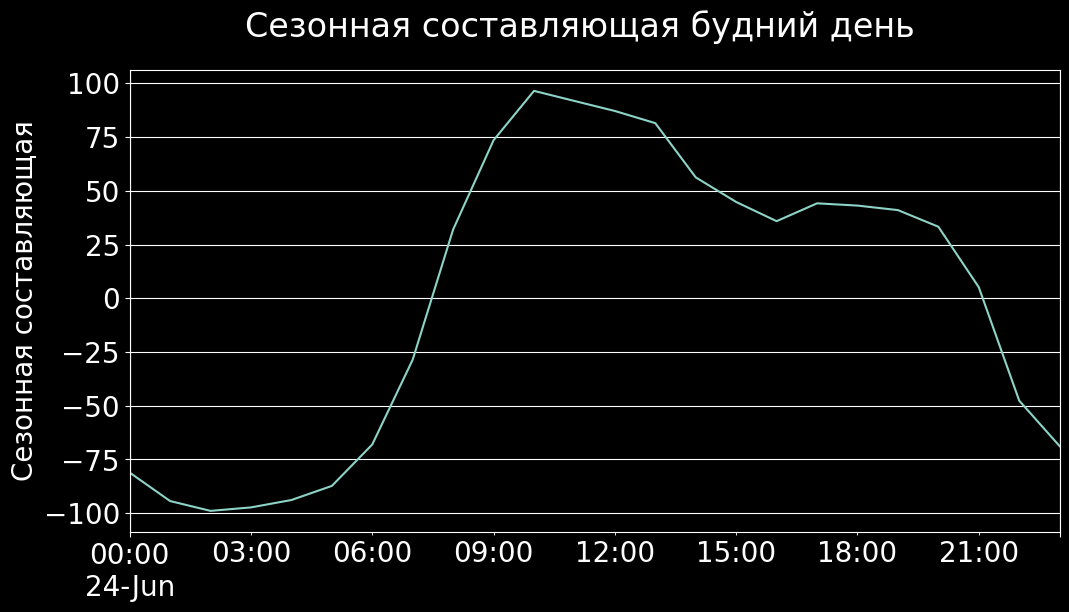

In [19]:
decomposed.seasonal['2024-06-24'].plot(ax=plt.gca(),
                                                   figsize=(12,6),
                                                   grid=True,
                                                   fontsize=20)

plt.suptitle('Сезонная составляющая будний день', fontsize=24)
plt.xlabel('', fontsize=20)
plt.ylabel('Сезонная составляющая', fontsize=20)

Text(0, 0.5, 'Сезонная составляющая')

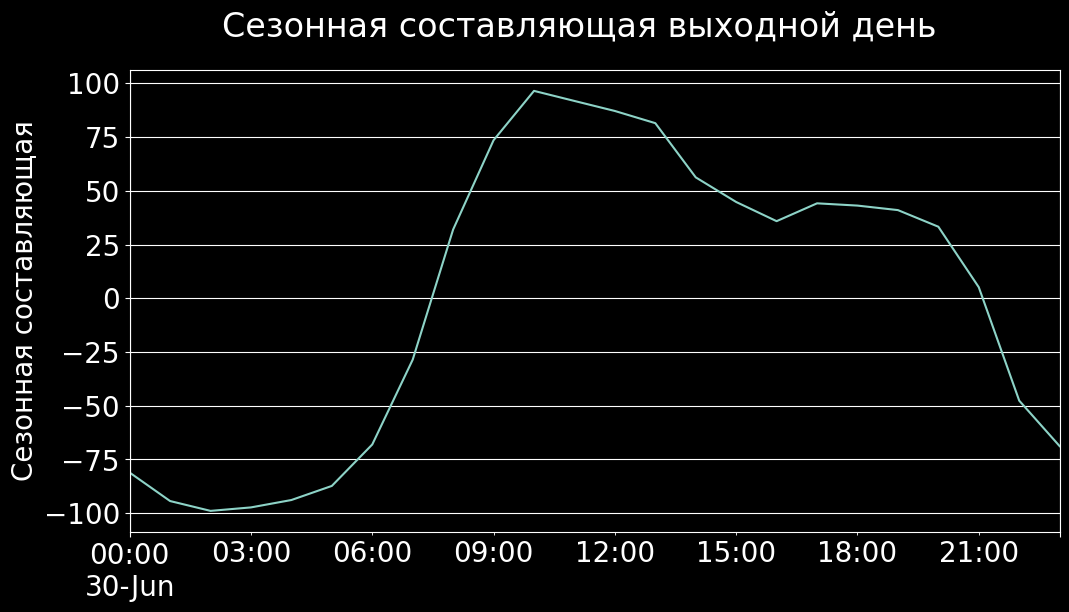

In [20]:
decomposed.seasonal['2024-06-30'].plot(ax=plt.gca(),
                                                   figsize=(12,6),
                                                   grid=True,
                                                   fontsize=20)

plt.suptitle('Сезонная составляющая выходной день', fontsize=24)
plt.xlabel('', fontsize=20)
plt.ylabel('Сезонная составляющая', fontsize=20)

### Train val

In [21]:
test_size = 24

In [22]:
train_test = orders_h[:-test_size]

In [23]:
val = orders_h[-test_size:]

In [24]:
print(train_test.index.min(), train_test.index.max())
print(val.index.min(), val.index.max())

2024-06-24 00:00:00 2024-07-06 23:00:00
2024-07-07 00:00:00 2024-07-07 23:00:00


## Base line

Спрогнозировать временные ряды без обучения можно двумя способами

1. Все значения тестовой выборки предсказываются одним и тем же числом (константой). Для метрики MAE — это медиана.

In [25]:
y_pred_median = np.ones(val['orders'].shape) * train_test['orders'].median()

In [26]:
print("MAE:", mean_absolute_error(val['orders'], y_pred_median))

MAE: 56.916666666666664


2. Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1). Этот способ не зависит от метрики.

In [27]:
y_pred_shift = val['orders'].shift()

In [28]:
y_pred_shift.iloc[0] = train_test['orders'].iloc[-1]

In [29]:
print("MAE:", mean_absolute_error(val['orders'], y_pred_shift))

MAE: 17.666666666666668


## Prophet

Проверим стационарность с помощью теста Дикки-Фуллера:

Если p-value меньше выбранного уровня значимости (0.05), временной ряд можно считать стационарным.

In [30]:
result = adfuller(train_test.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -9.69788203725093
p-value: 1.0919415630288336e-16


In [31]:
train_test.reset_index(inplace=True)

In [32]:
train_test = train_test.rename(columns={'Оформлен': 'ds', 'orders': 'y'})

Выполним экспотенциальное сглаживание

In [33]:
def exponential_smoothing_numba(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series``
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [34]:
#train_test['y'] = exponential_smoothing_numba(train_test['y'], 0.4)

In [35]:
train, test = train_test_split(train_test, shuffle=False, test_size=(24/len(train_test)))
train.dropna(inplace=True)

In [36]:
model_prophet = Prophet()
model_prophet.fit(train)

19:41:09 - cmdstanpy - INFO - Chain [1] start processing
19:41:09 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
future_train = model_prophet.make_future_dataframe(periods=24, freq='1h')

In [38]:
forecast = model_prophet.predict(future_train)

/home/dmitrii/Documents/Work/04_VkusWill/vw_env/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/dmitrii/Documents/Work/04_VkusWill/vw_env/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


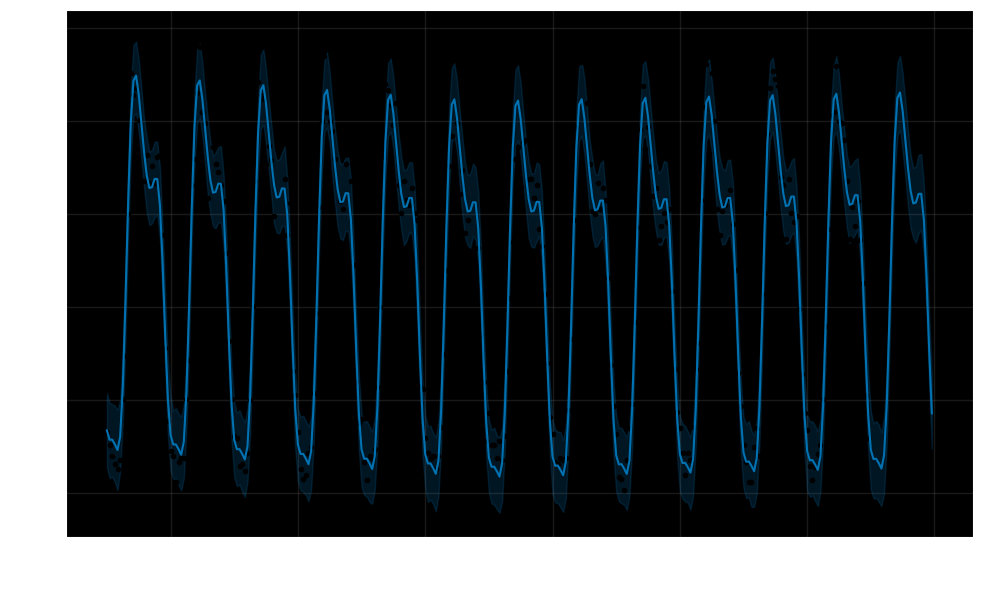

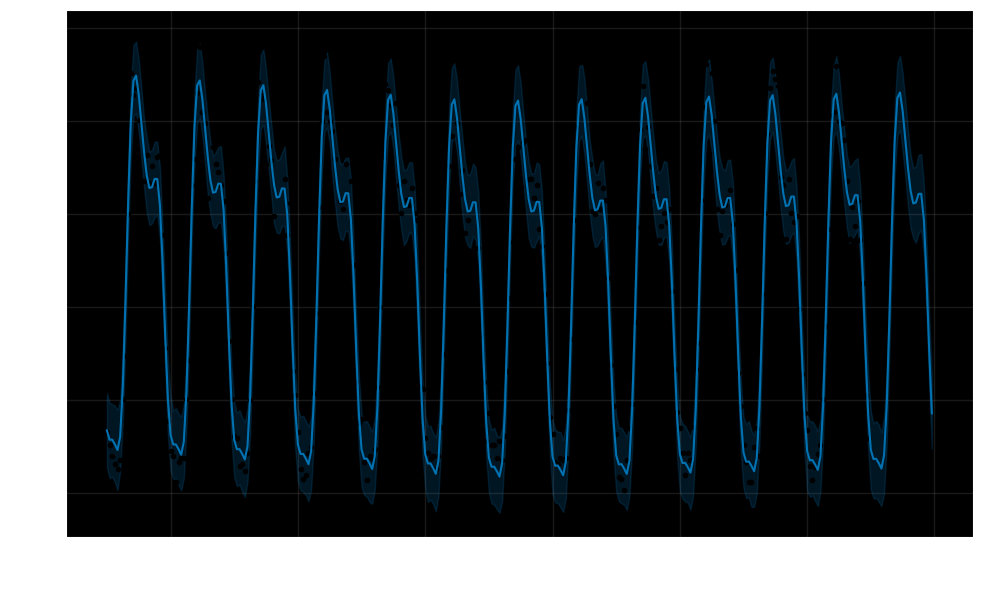

In [39]:
model_prophet.plot(forecast)

/home/dmitrii/Documents/Work/04_VkusWill/vw_env/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/dmitrii/Documents/Work/04_VkusWill/vw_env/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/home/dmitrii/Documents/Work/04_VkusWill/vw_env/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will re

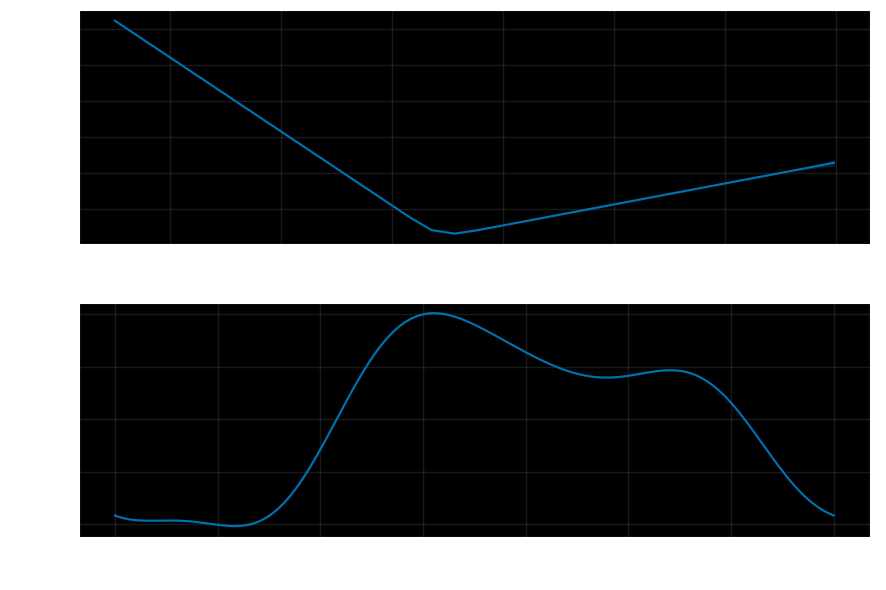

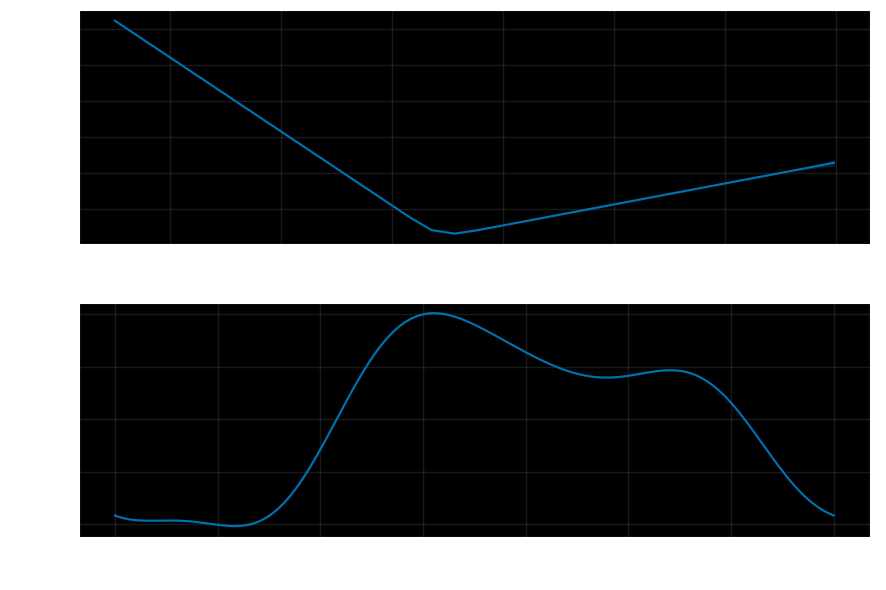

In [40]:
model_prophet.plot_components(forecast)

Используем столбцы trend, daily и weekly как признаки для обучения моделей.
Prophet предсказывает значение yhat, складывая значения столбцов trend, daily и weekly. Можно было бы использовать только значение yhat, лучше используем 3 признака.

In [41]:
features = forecast[['ds', 'trend', 'additive_terms', 'yhat', 'daily']]

Добавим к новому набору данных наши данные о количестве заказов

In [42]:
features = features.assign(y=train_test['y'])

In [43]:
features[:-24]

,ds,trend,additive_terms,yhat,daily,y
0,2024-06-24 00:00:00,125.547136,-91.622205,33.924931,-91.622205,33
1,2024-06-24 01:00:00,125.440501,-96.521051,28.919450,-96.521051,26
2,2024-06-24 02:00:00,125.333866,-96.402499,28.931367,-96.402499,20
3,2024-06-24 03:00:00,125.227231,-98.820706,26.406525,-98.820706,16
4,2024-06-24 04:00:00,125.120595,-101.728322,23.392274,-101.728322,13
...,...,...,...,...,...,...
283,2024-07-05 19:00:00,114.861961,45.479688,160.341648,45.479688,157
284,2024-07-05 20:00:00,114.892192,31.411868,146.304060,31.411868,136
285,2024-07-05 21:00:00,114.922423,0.738146,115.660569,0.738146,113
286,2024-07-05 22:00:00,114.952655,-38.551748,76.400907,-38.551748,53


In [44]:
f = features

In [45]:
f.rename(columns={'ds':'timestamp', 'y':'orders'}, inplace=True)

In [46]:
f

,timestamp,trend,additive_terms,yhat,daily,orders
0,2024-06-24 00:00:00,125.547136,-91.622205,33.924931,-91.622205,33
1,2024-06-24 01:00:00,125.440501,-96.521051,28.919450,-96.521051,26
2,2024-06-24 02:00:00,125.333866,-96.402499,28.931367,-96.402499,20
3,2024-06-24 03:00:00,125.227231,-98.820706,26.406525,-98.820706,16
4,2024-06-24 04:00:00,125.120595,-101.728322,23.392274,-101.728322,13
...,...,...,...,...,...,...
307,2024-07-06 19:00:00,115.587514,45.479688,161.067202,45.479688,111
308,2024-07-06 20:00:00,115.617746,31.411868,147.029613,31.411868,105
309,2024-07-06 21:00:00,115.647977,0.738146,116.386123,0.738146,96
310,2024-07-06 22:00:00,115.678208,-38.551748,77.126460,-38.551748,58


In [47]:
f.to_csv('features.csv', index=False, encoding='utf-8')

Установим индекс таблицы равным столбцу datetime.

In [48]:
features.index = pd.to_datetime(features['ds'])

KeyError: 'ds'

In [ ]:
features = features.set_index('ds')

In [ ]:
features.head()

,trend,additive_terms,yhat,daily,y
ds,,,,,
2024-06-24 00:00:00,125.547136,-91.622205,33.924931,-91.622205,33
2024-06-24 01:00:00,125.440501,-96.521051,28.919450,-96.521051,26
2024-06-24 02:00:00,125.333866,-96.402499,28.931367,-96.402499,20
2024-06-24 03:00:00,125.227231,-98.820706,26.406525,-98.820706,16
2024-06-24 04:00:00,125.120595,-101.728322,23.392274,-101.728322,13


In [ ]:
features.rename(columns={'y': 'orders'},inplace=True)

In [ ]:
print(features.index.min(), features.index.max())

2024-06-24 00:00:00 2024-07-06 23:00:00


## Feature ingineering

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for i in range(1, 24+1):
        data['lag_'+ str(i)] = data['orders'].shift(i)
        data['lag_' + str(i)] = data['lag_' + str(i)].fillna(method='ffill')

    data['rolling_mean'] = data['orders'].shift().rolling(rolling_mean_size).mean()
    data['is_weekend'] = (data.index.dayofweek >= 5) *1

    data['rolling_mean'].fillna(method='ffill', inplace=True)

In [ ]:
make_features(features, 24, 4)

/tmp/ipykernel_133792/535847943.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_' + str(i)] = data['lag_' + str(i)].fillna(method='ffill')
/tmp/ipykernel_133792/535847943.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_' + str(i)] = data['lag_' + str(i)].fillna(method='ffill')
/tmp/ipykernel_133792/535847943.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_' + str(i)] = data['lag_' + str(i)].fillna(method='ffill')
/tmp/ipykernel_133792/535847943.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_' + str(i)] = data['lag_' + str(i)].fillna(method='ffill')
/tmp/ipykernel_133792/535847943.

In [ ]:
features.dropna(inplace=True)

## Models

In [ ]:
train, test = train_test_split(features, shuffle=False, test_size=(24/len(features)))
train.dropna(inplace=True)

In [ ]:
X_train = features.drop('orders', axis=1)
y_train = features['orders']

In [ ]:
X_test = test.drop('orders', axis=1)
y_test = test['orders']

### Linear regression

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

In [ ]:
print("MAE обучающей выборки:", mean_absolute_error(y_train, y_pred_train))
print("MAE тестовой выборки:", mean_absolute_error(y_test, y_pred))

MAE обучающей выборки: 10.794133639668832
MAE тестовой выборки: 13.50286924867711


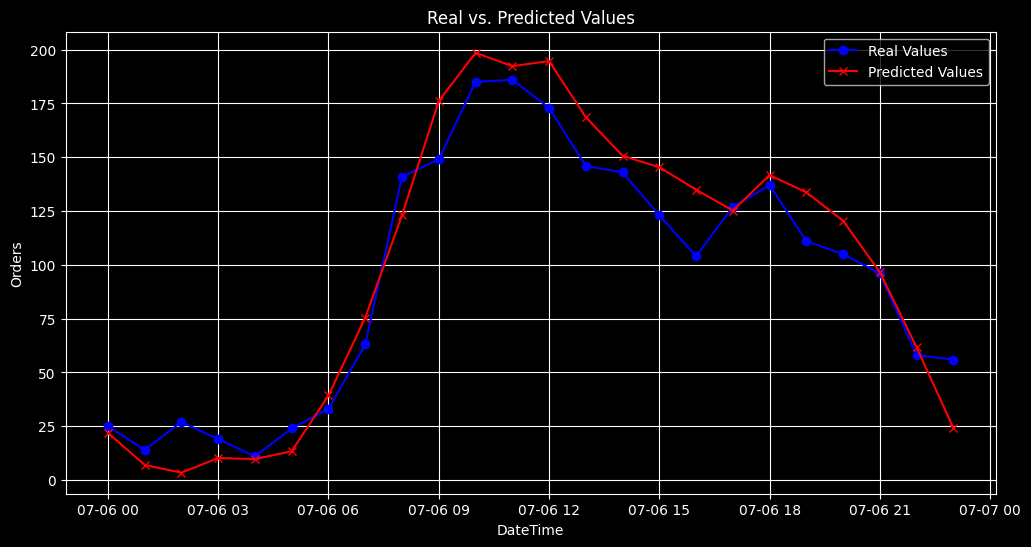

In [ ]:
# Plot the real data and predictions
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Real Values', marker='o', color='blue')
plt.plot(X_test.index, y_pred, label='Predicted Values', marker='x', color='red')
plt.xlabel('DateTime')
plt.ylabel('Orders')
plt.title('Real vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

### Catboost

In [ ]:
cbr = CatBoostRegressor(cat_features=['dayofweek','is_weekend', 'hour'],
                        random_state=42,
                        iterations=1000,
                        depth=10,
                        learning_rate=0.05,
                        loss_function='RMSE',
                        verbose=100)

In [ ]:
cbr.fit(X_train, y_train)

0:	learn: 69.0484909	total: 78.9ms	remaining: 1m 18s
100:	learn: 8.7432886	total: 2.52s	remaining: 22.4s
200:	learn: 4.9165862	total: 5.39s	remaining: 21.4s
300:	learn: 3.0523657	total: 8.34s	remaining: 19.4s
400:	learn: 1.9398042	total: 11.1s	remaining: 16.6s
500:	learn: 1.2754436	total: 13.9s	remaining: 13.8s
600:	learn: 0.8560270	total: 16.5s	remaining: 10.9s
700:	learn: 0.5658440	total: 19.1s	remaining: 8.13s
800:	learn: 0.3798732	total: 21.6s	remaining: 5.37s
900:	learn: 0.2657670	total: 24.2s	remaining: 2.66s
999:	learn: 0.1906534	total: 26.8s	remaining: 0us


In [ ]:
y_pred_cbr = cbr.predict(X_test)

In [ ]:
print("MAE тестовой выборки:", mean_absolute_error(y_test, y_pred_cbr))

MAE тестовой выборки: 2.1915957074397894


MAE тестовой выборки: 6.343888039140064

In [ ]:
mse = mean_squared_error(y_test, y_pred_cbr)

In [ ]:
#mse = mean_squared_error(y_test, y_pred_cbr)
print(f'MSE: {mse}')
print(f'RMSE: {np.sqrt(mse)}')

MSE: 10.562392176278005
RMSE: 3.2499834116927433


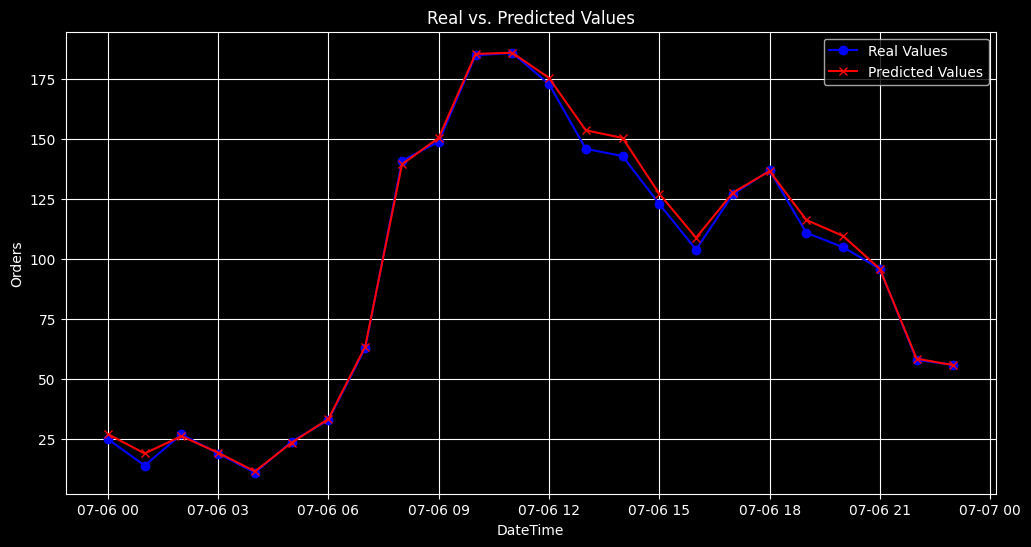

In [ ]:
# Plot the real data and predictions
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Real Values', marker='o', color='blue')
plt.plot(X_test.index, y_pred_cbr, label='Predicted Values', marker='x', color='red')
plt.xlabel('DateTime')
plt.ylabel('Orders')
plt.title('Real vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Pipeline

In [ ]:
#pipeline = Pipeline([
#    ('sort_index', SortIndexTransformer()),         # Сортировка индекса
#    ('resample', ResampleTransformer(freq='1h')),   # Ресемплинг данных с частотой 1 час
#    ('prophet', ProphetTransformer())               # Прогнозирование с помощью Prophet
#    ('scaler', StandardScaler()),
#    ('pca', PCA(n_components=2)),        # Шаг понижения размерности
#    ('classifier', RandomForestClassifier())  # Шаг классификации
#])

<>:4: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:4: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
/tmp/ipykernel_133792/1747850835.py:4: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('prophet', ProphetTransformer())               # Прогнозирование с помощью Prophet
/tmp/ipykernel_133792/1747850835.py:4: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('prophet', ProphetTransformer())               # Прогнозирование с помощью Prophet
/tmp/ipykernel_133792/1747850835.py:4: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('prophet', ProphetTransformer())               # Прогнозирование с помощью Prophet
/tmp/ipykernel_133792/1747850835.py:4: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('prophet', ProphetTransformer())               # Прогнозирование с помощью Prophet
/tmp/ipykernel_133792/1747850835.py:4:

TypeError: 'tuple' object is not callable

## Validation

#### prepare val

##### prophet

In [ ]:
model_prophet = Prophet()
model_prophet.fit(train_test)

19:37:52 - cmdstanpy - INFO - Chain [1] start processing
19:37:52 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future_test = model_prophet.make_future_dataframe(periods=24, freq='h')

In [ ]:
forecast = model_prophet.predict(future_test)

In [ ]:
df_test = forecast[['ds', 'trend', 'additive_terms', 'yhat', 'daily']]

In [ ]:
df_test.index = pd.to_datetime(df_test['ds'])

df_test = df_test.set_index('ds')

In [ ]:
# df_test = df_test.assign(y=val['orders'])

In [ ]:
df_test.rename(columns={'y': 'orders'},inplace=True)

In [ ]:
df_test = df_test.merge(train_test[['ds', 'y']], on='ds', how='left')

In [ ]:
df_test = df_test.set_index('ds')

In [ ]:
df_test.rename(columns={'y': 'orders'}, inplace=True)

In [ ]:
make_features(df_test, 24, 4)

/tmp/ipykernel_133792/535847943.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_' + str(i)] = data['lag_' + str(i)].fillna(method='ffill')
/tmp/ipykernel_133792/535847943.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_' + str(i)] = data['lag_' + str(i)].fillna(method='ffill')
/tmp/ipykernel_133792/535847943.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_' + str(i)] = data['lag_' + str(i)].fillna(method='ffill')
/tmp/ipykernel_133792/535847943.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_' + str(i)] = data['lag_' + str(i)].fillna(method='ffill')
/tmp/ipykernel_133792/535847943.

#### LinearReression

In [ ]:
#df_test.to_csv('features.csv', index=False, encoding='utf-8')

In [ ]:
df_test.drop('orders', axis=1, inplace=True)

In [ ]:
pred = model.predict(df_test[-24:])

In [ ]:
print("RMSE на тестовой выборке:", round(mean_squared_error(val, pred)**.5, 2))

RMSE на тестовой выборке: 26.93


In [ ]:
mean_absolute_error(val, pred)

22.32800404707108

In [ ]:
predictions = pd.DataFrame({
    'timestamp': val.index,
    'orders': pred
})

In [ ]:
predictions.to_csv('predictions.csv', index=False, encoding='utf-8')

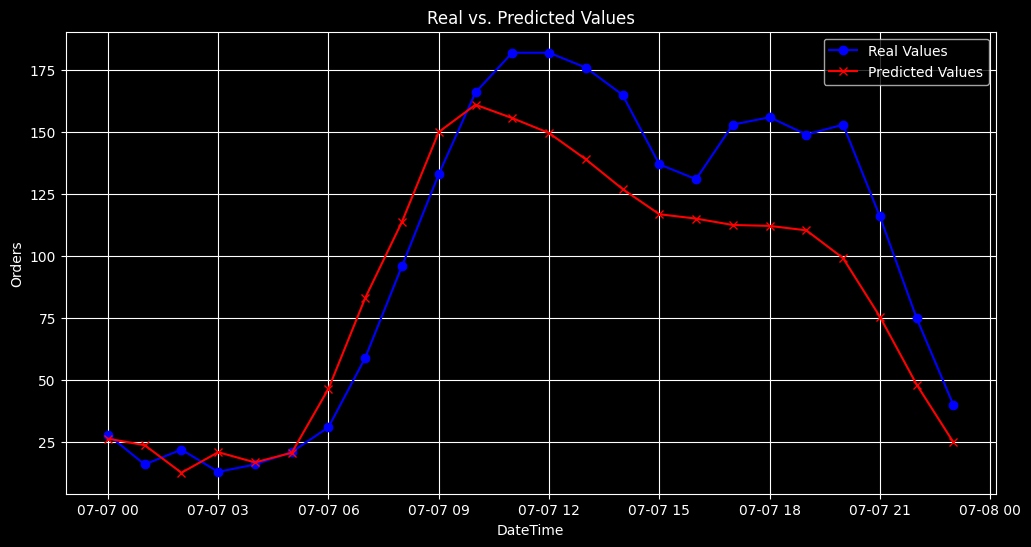

In [ ]:
# Plot the real data and predictions
plt.figure(figsize=(12, 6))
plt.plot(val.index, val, label='Real Values', marker='o', color='blue')
plt.plot(val.index, pred, label='Predicted Values', marker='x', color='red')
plt.xlabel('DateTime')
plt.ylabel('Orders')
plt.title('Real vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

#### CatBoost

In [ ]:
y_pred_cbr = cbr.predict(df_test[-24:])
print("RMSE на тестовой выборке:", round(mean_squared_error(val, y_pred_cbr)**.5, 2))

RMSE на тестовой выборке: 23.78


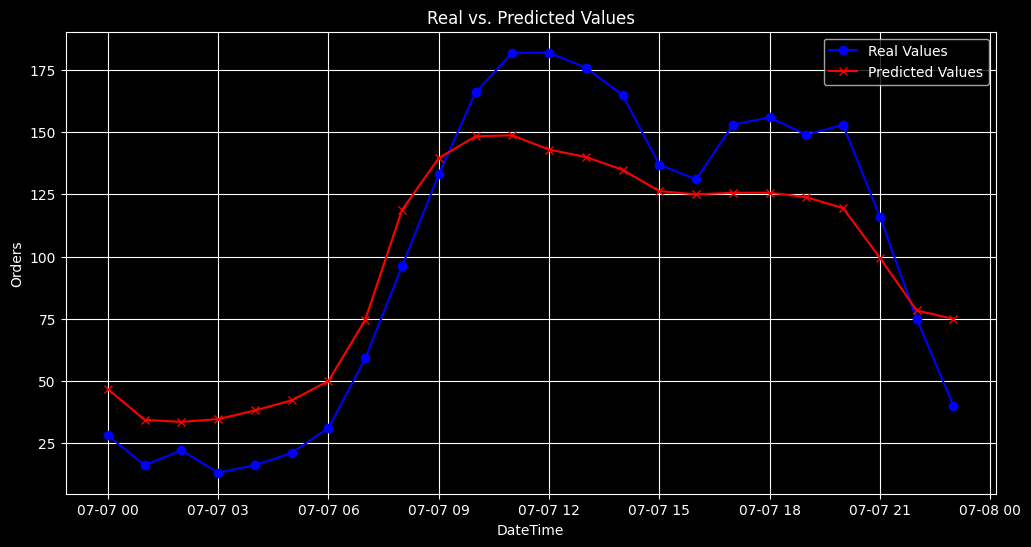

In [ ]:
# Plot the real data and predictions
plt.figure(figsize=(12, 6))
plt.plot(val.index, val, label='Real Values', marker='o', color='blue')
plt.plot(val.index, y_pred_cbr, label='Predicted Values', marker='x', color='red')
plt.xlabel('DateTime')
plt.ylabel('Orders')
plt.title('Real vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()